Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/

Code for Examples 12.22 and 12.32

We use a toy example to illustrate how feature collinearity results affects the ordinary-least-squares estimator, leading to overfitting, and how ridge regression mitigates this issue. In the example the response is a linear function of the features corrupted by additive noise\
Topics and relevant videos: [Linear regression, ordinary least squares](https://www.youtube.com/watch?v=Ktdh6qXeakA), [coefficient error, feature collinearity, overfitting](https://www.youtube.com/watch?v=YD607IJa4hs), [ridge regression, regularization](https://www.youtube.com/watch?v=uv8H6RiFhdE)

Author: Carlos Fernandez-Granda

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.random import default_rng
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
font_size = 15
font_size_ticks = 15
np.set_printoptions(precision=3)

msize = 50

Features [[ 0.455  0.97  -1.518  0.094]
 [ 0.44   1.025 -1.508  0.043]]
Correlation between features 0.9992
Covariance matrix of features [[1.154 1.163]
 [1.163 1.173]]
Inverse of the covariance matrix [[ 520.908 -516.142]
 [-516.142  512.273]]
Eigenvector 1 [0.704 0.71 ]
Eigenvalue 1 2.326
Eigenvector 2 [-0.71   0.704]
Eigenvalue 2 0.001
Inverse of eigenvalue 1 0.43
Inverse of eigenvalue 2 1032.751
Noise [-0.126 -0.078  0.01  -0.181]
Response [ 0.326  0.906 -1.506 -0.101]
Cross-covariance of features and noise [-0.055 -0.053]
Inner products with eigenvectors [0.002 0.076]
OLS coefficients [-0.711  1.653]
OLS coefficients sanity check [-0.711  1.653]
y_OLS [ 0.404  1.005 -1.412  0.004]
y_true [ 0.451  0.983 -1.516  0.081]
Training error OLS 0.0355
True error 0.0549


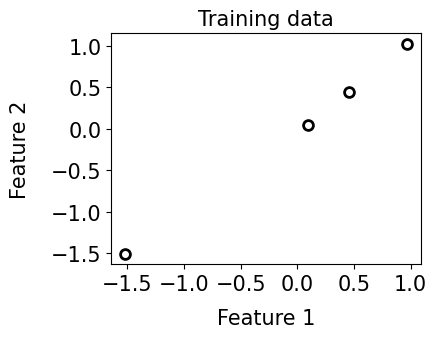

In [2]:
rng = default_rng(2023) 
n = 4
rho = 0.999 
cov_matrix = np.array([[1,rho],[rho,1]])
sigma = 0.2
true_beta = np.array([0.75,0.25])

eigvals_cov,eigvecs_cov = np.linalg.eig(cov_matrix)
coloring_matrix = eigvecs_cov @ np.diag(np.sqrt(eigvals_cov)) 
iid_gaussian = rng.standard_normal(size=(2,n))
X_raw = coloring_matrix @ iid_gaussian 
X = X_raw - X_raw.mean(axis=1, keepdims=True)
print("Features",X)
print("Correlation between features",round(np.corrcoef(X)[0,1],4))
Sigma_X =np.cov(X,ddof=1)
print("Covariance matrix of features",Sigma_X)
inv_Sigma_X = np.linalg.inv(Sigma_X)
print("Inverse of the covariance matrix",inv_Sigma_X)
eigvals_Sigma_X,eigvecs_Sigma_X = np.linalg.eig(Sigma_X)
u_1 = -eigvecs_Sigma_X[:,1]
u_2 = eigvecs_Sigma_X[:,0]
lambda_1 = eigvals_Sigma_X[1]
lambda_2 = eigvals_Sigma_X[0]
eigenvector_matrix = np.column_stack((u_1, u_2))
eigenvalue_matrix = np.diag(np.array([lambda_1,lambda_2]))
print("Eigenvector 1",u_1)
print("Eigenvalue 1",round(lambda_1,3))
print("Eigenvector 2",u_2)
print("Eigenvalue 2",round(lambda_2,3))
print("Inverse of eigenvalue 1",round(1/lambda_1,3))
print("Inverse of eigenvalue 2",round(1/lambda_2,3))
z = sigma * rng.standard_normal(n)
y = X.T @ true_beta + z
print("Noise",z)
print("Response",y)

Sigma_XZ = (X@z)/(n-1)
print("Cross-covariance of features and noise",Sigma_XZ)
print("Inner products with eigenvectors",Sigma_XZ.T @ eigvecs_Sigma_X)
print("OLS coefficients",
      true_beta + eigenvector_matrix @ np.linalg.inv(eigenvalue_matrix) @ eigenvector_matrix.T @ Sigma_XZ)

linear_model = LinearRegression(fit_intercept=False).fit(X.T, y)
print("OLS coefficients sanity check",linear_model.coef_)

y_OLS = X.T @ linear_model.coef_
print("y_OLS",y_OLS)
print("y_true",y-z)
print("Training error OLS",round(np.sum((y-y_OLS)**2),4))
print("True error",round(np.sum(z**2),4))

plt.figure(figsize=(4,3))
plt.scatter(X[0,:],X[1,:],s=msize,color="white",edgecolor='black',lw=2, rasterized=True)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel('Feature 1',fontsize=font_size,labelpad = 10)
plt.ylabel('Feature 2',fontsize=font_size,labelpad = 15)
plt.title("Training data",fontsize=font_size);

In [3]:
lambda_val = 0.1 * (n-1) 
ridge_model = Ridge(alpha=lambda_val,fit_intercept=False).fit(X.T, y)
print("True coefficients",true_beta)
c_true = true_beta.T @ eigenvector_matrix
print("Inner products with eigenvectors",c_true)

print("OLS coefficients",linear_model.coef_)
print("Ridge-regression coefficients",ridge_model.coef_)

print("Cross-covariance of features and noise",Sigma_XZ)
aux_XZ = Sigma_XZ.T @ eigenvector_matrix
print("Inner products with eigenvectors",aux_XZ)

aux_c_OLS_1 = aux_XZ[0]/lambda_1
aux_c_OLS_2 = aux_XZ[1]/lambda_2
print("u_1^T Sigma_{XZ} / xi_1",round(aux_c_OLS_1,3))
print("u_2^T Sigma_{XZ} / xi_2",round(aux_c_OLS_2,3))

c_OLS = c_true + np.array([aux_c_OLS_1,aux_c_OLS_2])
print("OLS coefficient sanity check",linear_model.coef_,eigenvector_matrix@c_OLS)

c_RR =[(lambda_1*c_true[0] + aux_XZ[0])/(lambda_1 + lambda_val/(n-1)),
      (lambda_2*c_true[1] + aux_XZ[1])/(lambda_2 + lambda_val/(n-1))] 
print("c_RR",np.round(c_RR,4))
print("Ridge-regression coefficient sanity check",
      eigenvector_matrix@c_RR)

y_ridge = X.T @ ridge_model.coef_
print("y",y)
print("y_OLS",y_OLS)
print("y_ridge",y_ridge)
print("y_true",y-z)
print("Training error OLS",round(np.sum((y-y_OLS)**2),4))
print("Training error ridge regression",round(np.sum((y-y_ridge)**2),4))

True coefficients [0.75 0.25]
Inner products with eigenvectors [ 0.706 -0.357]
OLS coefficients [-0.711  1.653]
Ridge-regression coefficients [0.443 0.469]
Cross-covariance of features and noise [-0.055 -0.053]
Inner products with eigenvectors [-0.076  0.002]
u_1^T Sigma_{XZ} / xi_1 -0.033
u_2^T Sigma_{XZ} / xi_2 2.025
OLS coefficient sanity check [-0.711  1.653] [-0.711  1.653]
c_RR [0.645 0.016]
Ridge-regression coefficient sanity check [0.443 0.469]
y [ 0.326  0.906 -1.506 -0.101]
y_OLS [ 0.404  1.005 -1.412  0.004]
y_ridge [ 0.408  0.911 -1.38   0.061]
y_true [ 0.451  0.983 -1.516  0.081]
Training error OLS 0.0355
Training error ridge regression 0.0488


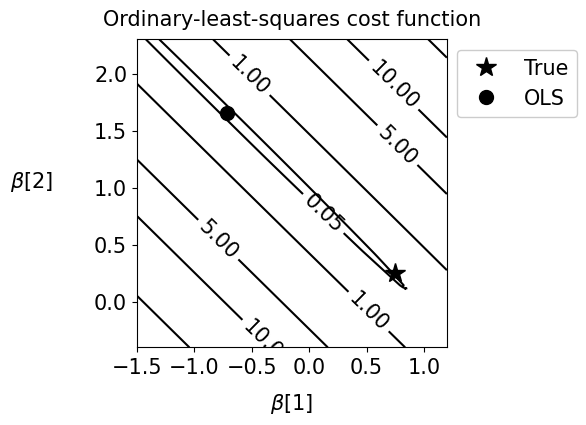

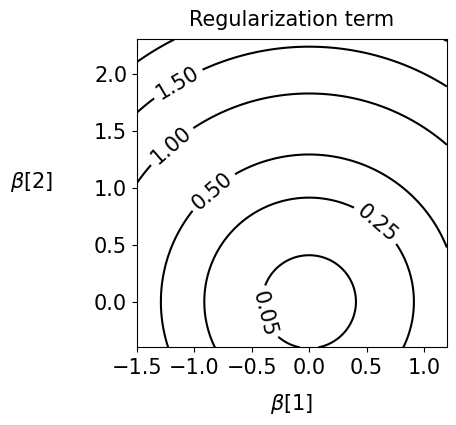

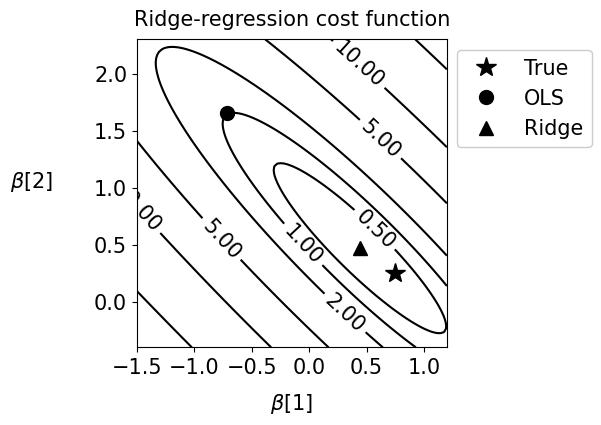

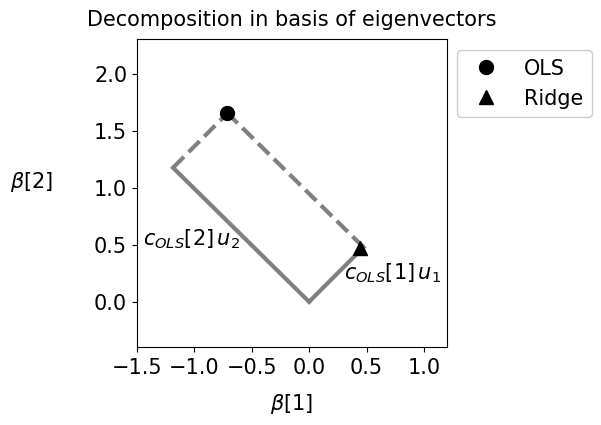

In [5]:
beta_min_1 = -1.5
beta_min_2 = -0.4
beta_max_1 = 1.2
beta_max_2 = 2.3

beta_grid_1 = np.linspace(beta_min_1, beta_max_1, 100)
beta_grid_2 = np.linspace(beta_min_2, beta_max_2, 100)

def OLS(beta_1,beta_2):
    return (np.sum((y-X[0,:]*beta_1-X[1,:]*beta_2)**2))

def reg(beta_1,beta_2,lambda_val):
    return lambda_val*(beta_1**2 + beta_2**2)

def ridge(beta_1,beta_2,lambda_val):
    return (np.sum((y-X[0,:]*beta_1-X[1,:]*beta_2)**2) 
            + lambda_val*(beta_1**2 + beta_2**2))

grid_1, grid_2 = np.meshgrid(beta_grid_1, beta_grid_2)

OLS_vec=np.vectorize(OLS)
grid_OLS = OLS_vec(grid_1,grid_2)

linear_model = LinearRegression().fit(X.T, y)
beta_OLS = linear_model.coef_

level_list = [0.05,1,5,10,20]
markersize = 10

fig = plt.figure(figsize = (4,4)) 
CS = plt.contour(grid_1, grid_2, grid_OLS, levels = level_list,colors='black')#levels=30,cmap='RdGy',alpha=1);
plt.plot(true_beta[0],true_beta[1],ls="None",color='black',ms=markersize+5,marker="*",label="True")
plt.plot(beta_OLS[0],beta_OLS[1],ls="None",color='black',ms=markersize,marker="o",label="OLS")
plt.clabel(CS, fontsize=font_size_ticks, inline=1,fmt = '%1.2f')
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel(r'$\beta[1]$', fontsize=font_size,labelpad=10)
h = plt.ylabel(r'$\beta [2] $', fontsize=font_size,labelpad=45)
h.set_rotation(0)
plt.legend(fontsize=font_size_ticks,framealpha=1,bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.title("Ordinary-least-squares cost function",fontsize=font_size,pad=10)

level_list = [0.05,0.25,0.5,1,1.5,2,3,4,5,10,20]

lambda_val = 0.1 * (n-1)
grid_reg = reg(grid_1,grid_2,lambda_val)

fig = plt.figure(figsize = (4,4)) 
CS = plt.contour(grid_1, grid_2, grid_reg, levels = level_list,colors='black')#levels=30,cmap='RdGy',alpha=1);
plt.clabel(CS, fontsize=font_size_ticks, inline=1,fmt = '%1.2f')#,ticks=Contourrange)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel(r'$\beta[1]$', fontsize=font_size,labelpad=10)
h = plt.ylabel(r'$\beta [2] $', fontsize=font_size,labelpad=45)
h.set_rotation(0)
plt.title("Regularization term",fontsize=font_size,pad=10)

level_list = [0.5,1,2,5,10,20]

ridge_vec=np.vectorize(ridge)
grid_ridge = ridge_vec(grid_1,grid_2,lambda_val)

ridge_lambda = Ridge(alpha=lambda_val,fit_intercept=False)
ridge_model = ridge_lambda.fit(X.T, y)
beta_ridge = ridge_model.coef_

fig = plt.figure(figsize = (4,4)) 
CS = plt.contour(grid_1, grid_2, grid_ridge, levels = level_list,colors='black')#levels=30,cmap='RdGy',alpha=1);
plt.plot(true_beta[0],true_beta[1],ls="None",color='black',ms=markersize+5,marker="*",label="True")
plt.plot(beta_OLS[0],beta_OLS[1],ls="None",color='black',ms=markersize,marker="o",label="OLS")
plt.plot(beta_ridge[0],beta_ridge[1],ls="None",color='black',ms=markersize,marker="^",label="Ridge")
plt.clabel(CS, fontsize=font_size_ticks, inline=1,fmt = '%1.2f')
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel(r'$\beta[1]$', fontsize=font_size,labelpad=10)
h = plt.ylabel(r'$\beta[2] $', fontsize=font_size,labelpad=45)
h.set_rotation(0)
plt.legend(fontsize=font_size_ticks,framealpha=1,bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.title("Ridge-regression cost function",fontsize=font_size,pad=10);

fig = plt.figure(figsize = (4,4)) 
plt.plot([0,c_OLS[0]*u_1[0]],[0,c_OLS[0]*u_1[1]],ls="solid",color='gray',lw=3)
plt.plot([c_OLS[0]*u_1[0],beta_OLS[0]],[c_OLS[0]*u_1[1],beta_OLS[1]],ls="dashed",color='gray',lw=3)
plt.plot([c_OLS[1]*u_2[0],beta_OLS[0]],[c_OLS[1]*u_2[1],beta_OLS[1]],ls="dashed",color='gray',lw=3)
plt.plot([0,c_OLS[1]*u_2[0]],[0,c_OLS[1]*u_2[1]],ls="solid",color='gray',lw=3)
plt.plot(beta_OLS[0],beta_OLS[1],ls="None",color='black',ms=markersize,marker="o",label="OLS")
plt.plot(beta_ridge[0],beta_ridge[1],ls="None",color='black',ms=markersize,marker="^",label="Ridge")
plt.text(0.3,0.2,r"$c_{OLS}[1]\,u_1$",fontsize=font_size_ticks)
plt.text(-1.45,0.5,r"$c_{OLS}[2]\,u_2$",fontsize=font_size_ticks)
plt.xlim([beta_min_1,beta_max_1])
plt.ylim([beta_min_2,beta_max_2])
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel(r'$\beta[1]$', fontsize=font_size,labelpad=10)
h = plt.ylabel(r'$\beta [2] $', fontsize=font_size,labelpad=45)
h.set_rotation(0)
plt.legend(fontsize=font_size_ticks,framealpha=1,bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.title("Decomposition in basis of eigenvectors",fontsize=font_size,pad=10);

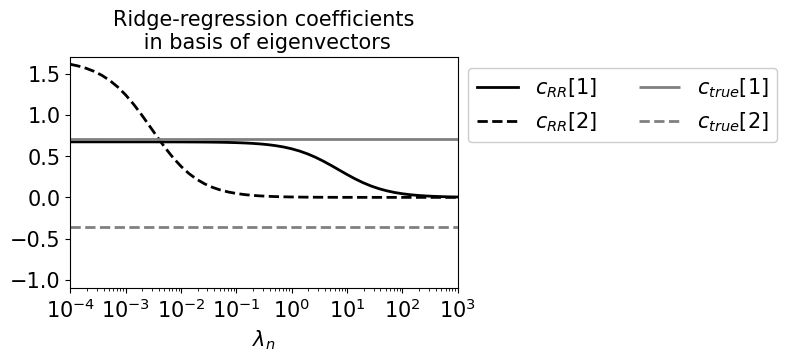

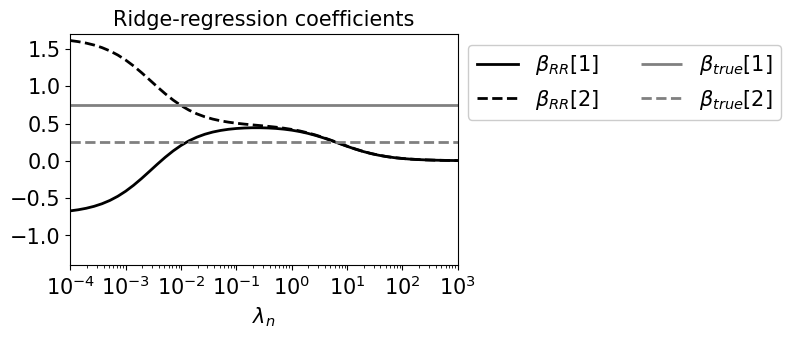

In [6]:
line_width = 2
lambda_grid = np.logspace(-4,3)

c_RR_1 =(lambda_1*c_true[0] + aux_XZ[0])/(lambda_1 + lambda_grid/(n-1))
c_RR_2 =(lambda_2*c_true[1] + aux_XZ[1])/(lambda_2 + lambda_grid/(n-1))

coeffs_RR = np.zeros((2,len(lambda_grid)))
for ind_lambda,lambda_value in enumerate(lambda_grid):
    ridge_model_lambda = Ridge(alpha=lambda_value,fit_intercept=False).fit(X.T, y)
    coeffs_RR[:,ind_lambda] = ridge_model_lambda.coef_

fig = plt.figure(figsize = (5,3)) 
plt.semilogx(lambda_grid,c_RR_1,ls="solid",lw=line_width,color ="black",label=r'$c_{RR}[1]$')
plt.semilogx(lambda_grid,c_RR_2,ls="dashed",lw=line_width,color ="black",label=r'$c_{RR}[2]$')
plt.hlines(c_true[0], lambda_grid[0], lambda_grid[-1],lw=line_width,ls="solid",color ="gray",label=r'$c_{true}[1]$')
plt.hlines(c_true[1], lambda_grid[0], lambda_grid[-1],lw=line_width,ls="dashed",color ="gray",label=r'$c_{true}[2]$')
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylim([-1.1,1.7])
plt.xlim([lambda_grid[0], lambda_grid[-1]])
plt.legend(fontsize=font_size_ticks,framealpha=1,bbox_to_anchor=(1, 1), loc='upper left', ncol=2)
plt.xlabel(r'$\lambda_{n}$',fontsize=font_size,labelpad = 5)
plt.title('Ridge-regression coefficients\n in basis of eigenvectors',fontsize=font_size)

fig = plt.figure(figsize = (5,3)) 
plt.semilogx(lambda_grid,coeffs_RR[0],ls="solid",lw=line_width,color ="black",label=r'$\beta_{RR}[1]$')
plt.semilogx(lambda_grid,coeffs_RR[1],ls="dashed",lw=line_width,color ="black",label=r'$\beta_{RR}[2]$')
plt.hlines(true_beta[0], lambda_grid[0], lambda_grid[-1],lw=line_width,color ="gray",label=r'$\beta_{true}[1]$')
plt.hlines(true_beta[1], lambda_grid[0], lambda_grid[-1],lw=line_width,ls="dashed",color ="gray",label=r'$\beta_{true}[2]$')
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylim([-1.4,1.7])
plt.xlim([lambda_grid[0], lambda_grid[-1]])
plt.legend(fontsize=font_size_ticks,framealpha=1,bbox_to_anchor=(1, 1), loc='upper left', ncol=2)
plt.xlabel(r'$\lambda_{n}$',fontsize=font_size,labelpad = 5)
plt.title('Ridge-regression coefficients',fontsize=font_size);